In [25]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

In [26]:
# Define dataset paths
train_dataset_path = '/content/dataset/train'
val_dataset_path = '/content/dataset/val'

IMG_SIZE = (100, 100)

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype('float32') / 255.0
    return img

def generate_pairs(dataset_path, num_pairs=10000):
    people = os.listdir(dataset_path)
    pairs = []
    labels = []

    for _ in tqdm(range(num_pairs // 2)):  # half positive, half negative
        # Positive pair
        person = random.choice(people)
        person_folder = os.path.join(dataset_path, person)
        images = os.listdir(person_folder)
        if len(images) < 2:
            continue
        img1, img2 = random.sample(images, 2)
        pairs.append([preprocess_image(os.path.join(person_folder, img1)),
                      preprocess_image(os.path.join(person_folder, img2))])
        labels.append(1)

        # Negative pair
        person1, person2 = random.sample(people, 2)
        folder1 = os.path.join(dataset_path, person1)
        folder2 = os.path.join(dataset_path, person2)
        img1 = random.choice(os.listdir(folder1))
        img2 = random.choice(os.listdir(folder2))
        pairs.append([preprocess_image(os.path.join(folder1, img1)),
                      preprocess_image(os.path.join(folder2, img2))])
        labels.append(0)

    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs[:, 0], pairs[:, 1], labels

In [27]:
# Generate train and validation pairs
X1_train, X2_train, y_train = generate_pairs(train_dataset_path, num_pairs=10000)
X1_val, X2_val, y_val = generate_pairs(val_dataset_path, num_pairs=2000)

# Add channel dimension
X1_train = np.expand_dims(X1_train, -1)
X2_train = np.expand_dims(X2_train, -1)
X1_val = np.expand_dims(X1_val, -1)
X2_val = np.expand_dims(X2_val, -1)

def build_base_model(input_shape):
    inputs = Input(input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs, x)

def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, y_pred.dtype)
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

def euclidean_distance(vectors):
    x, y = vectors
    return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True))

def build_siamese_model(base_model, loss_type='bce'):
    input_1 = Input((*IMG_SIZE, 1))
    input_2 = Input((*IMG_SIZE, 1))

    feat_1 = base_model(input_1)
    feat_2 = base_model(input_2)

    if loss_type == 'bce':
        merged = Lambda(lambda x: tf.abs(x[0] - x[1]))([feat_1, feat_2])
        output = Dense(1, activation='sigmoid')(merged)
        model = Model(inputs=[input_1, input_2], outputs=output)
        model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    elif loss_type == 'contrastive':
        distance = Lambda(euclidean_distance)([feat_1, feat_2])
        model = Model(inputs=[input_1, input_2], outputs=distance)
        model.compile(loss=contrastive_loss, optimizer=Adam())

    return model

100%|██████████| 1000/1000 [00:01<00:00, 871.00it/s]


In [28]:
# Train BCE and Contrastive Models
base_bce = build_base_model((*IMG_SIZE, 1))
bce_model = build_siamese_model(base_bce, loss_type='bce')

base_contrast = build_base_model((*IMG_SIZE, 1))
contrast_model = build_siamese_model(base_contrast, loss_type='contrastive')




In [29]:

history_bce = bce_model.fit([X1_train, X2_train], y_train,
                           validation_data=([X1_val, X2_val], y_val),
                           epochs=10)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.5831 - loss: 0.6653 - val_accuracy: 0.6250 - val_loss: 0.6500
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.6885 - loss: 0.5873 - val_accuracy: 0.6670 - val_loss: 0.6344
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.7777 - loss: 0.4860 - val_accuracy: 0.6595 - val_loss: 0.7112
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.8276 - loss: 0.3868 - val_accuracy: 0.6815 - val_loss: 0.7021
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9015 - loss: 0.2593 - val_accuracy: 0.6795 - val_loss: 0.8936
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9450 - loss: 0.1651 - val_accuracy: 0.6755 - val_loss: 1.0656
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9691 - loss: 0.0993 - val_accuracy: 0.6635 - val_loss: 1.3434
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9773 - loss: 0.0691 - 

In [30]:
history_contrast = contrast_model.fit([X1_train, X2_train], y_train,
                                     validation_data=([X1_val, X2_val], y_val),
                                     epochs=10)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.3274 - val_loss: 0.2267
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.1864 - val_loss: 0.2268
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.1652 - val_loss: 0.2220
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.1503 - val_loss: 0.2167
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.1316 - val_loss: 0.2345
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.1116 - val_loss: 0.2321
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0977 - val_loss: 0.2487
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0869 - val_loss: 0.2510
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - loss: 0.0753 - val_loss: 0.2702
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0605 - val_loss: 0.2784


In [31]:
def create_triplets(X, y):
    triplets = []
    unique_labels = np.unique(y)
    label_to_indices = {label: np.where(y == label)[0] for label in unique_labels}

    for i in range(len(X)):
        anchor = X[i]
        label = y[i]
        pos_idx = random.choice(label_to_indices[label])
        while pos_idx == i:
            pos_idx = random.choice(label_to_indices[label])
        pos = X[pos_idx]

        neg_label = random.choice([l for l in unique_labels if l != label])
        neg_idx = random.choice(label_to_indices[neg_label])
        neg = X[neg_idx]

        triplets.append((anchor, pos, neg))

    anchors, positives, negatives = zip(*triplets)
    return np.array(anchors), np.array(positives), np.array(negatives)

# For simplicity, reuse X1 and y
anchors_train, positives_train, negatives_train = create_triplets(X1_train, y_train)
anchors_val, positives_val, negatives_val = create_triplets(X1_val, y_val)

def triplet_loss(margin=0.5):
    def loss(y_true, y_pred):
        anchor, positive, negative = tf.split(y_pred, num_or_size_splits=3, axis=1)
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss

def build_triplet_model(base_model):
    input_a = Input((*IMG_SIZE, 1))
    input_p = Input((*IMG_SIZE, 1))
    input_n = Input((*IMG_SIZE, 1))

    feat_a = base_model(input_a)
    feat_p = base_model(input_p)
    feat_n = base_model(input_n)

    merged = Lambda(lambda x: tf.concat(x, axis=1))([feat_a, feat_p, feat_n])
    model = Model([input_a, input_p, input_n], merged)
    model.compile(loss=triplet_loss(), optimizer=Adam())
    return model

In [32]:


base_triplet = build_base_model((*IMG_SIZE, 1))
triplet_model = build_triplet_model(base_triplet)

history_triplet = triplet_model.fit([anchors_train, positives_train, negatives_train],
                                   np.zeros(len(anchors_train)),
                                   validation_data=([anchors_val, positives_val, negatives_val],
                                                   np.zeros(len(anchors_val))),
                                   epochs=10)

def plot_all_trainings(histories, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for ax, history, title in zip(axes, histories, titles):
        ax.plot(history.history['loss'], label='Train Loss')
        if 'val_loss' in history.history:
            ax.plot(history.history['val_loss'], label='Val Loss')
        if 'accuracy' in history.history:
            ax.plot(history.history['accuracy'], label='Accuracy')
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Value')
        ax.grid(True)
        ax.legend()

    plt.suptitle("Training Curves Comparison", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 49s 51ms/step - loss: 0.5562 - val_loss: 0.5018
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 0.4997 - val_loss: 0.5000
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 0.5000 - val_loss: 0.5000
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - loss: 0.5001 - val_loss: 0.5000
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 0.5001 - val_loss: 0.5000


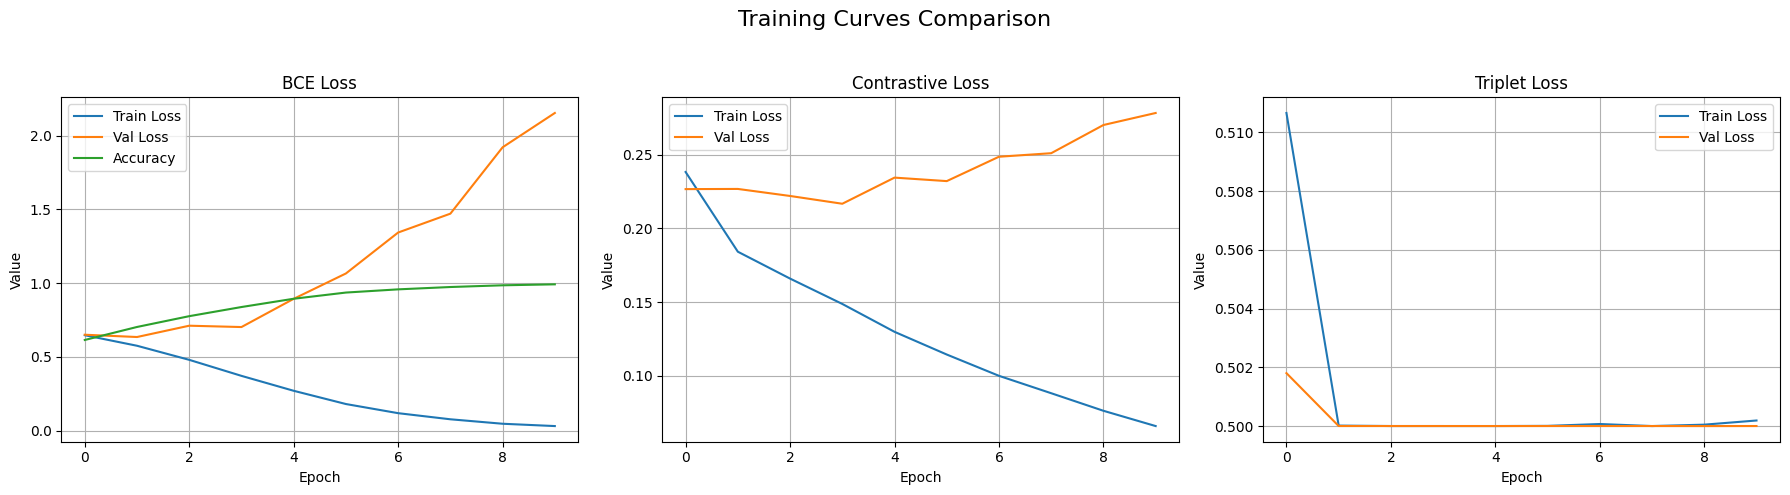

In [33]:
# Plot training histories
plot_all_trainings(
    [history_bce, history_contrast, history_triplet],
    ['BCE Loss', 'Contrastive Loss', 'Triplet Loss']
)

In [34]:
def show_test_result(model, img1_path, img2_path, loss_type='bce', base_model=None):
    img1 = preprocess_image(img1_path)
    img2 = preprocess_image(img2_path)
    img1_input = np.expand_dims(img1, axis=(0, -1))
    img2_input = np.expand_dims(img2, axis=(0, -1))

    if loss_type == 'bce':
        pred = model.predict([img1_input, img2_input])[0][0]
        title = f"BCE Model Prediction: {pred:.4f}"

    elif loss_type == 'contrastive':
        distance = model.predict([img1_input, img2_input])[0][0]
        title = f"Contrastive Distance: {distance:.4f}"

    elif loss_type == 'triplet':
        if base_model is None:
            raise ValueError("For triplet, pass the base_model used inside triplet_model.")
        feat1 = base_model.predict(img1_input)
        feat2 = base_model.predict(img2_input)
        dist = np.sqrt(np.sum((feat1 - feat2) ** 2))
        title = f"Triplet Embedding Distance: {dist:.4f}"

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(img1, cmap='gray')
    axs[0].set_title("Image 1")
    axs[0].axis('off')
    axs[1].imshow(img2, cmap='gray')
    axs[1].set_title("Image 2")
    axs[1].axis('off')
    plt.suptitle(title)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step


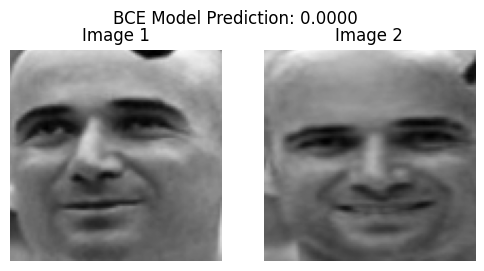

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


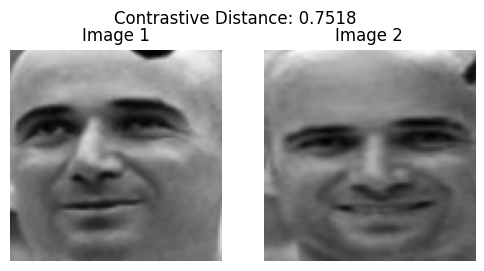

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


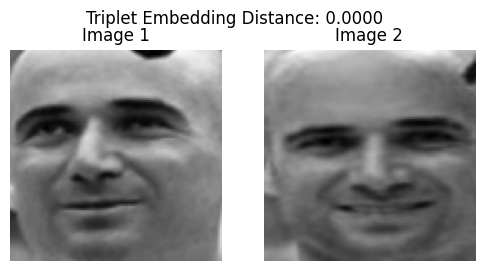

In [35]:
show_test_result(bce_model, "/content/dataset/val/Andre_Agassi/Andre_Agassi_0017.jpg", "/content/dataset/val/Andre_Agassi/Andre_Agassi_0023.jpg", loss_type='bce')
show_test_result(contrast_model, "/content/dataset/val/Andre_Agassi/Andre_Agassi_0017.jpg", "/content/dataset/val/Andre_Agassi/Andre_Agassi_0023.jpg", loss_type='contrastive')
show_test_result(triplet_model, "/content/dataset/val/Andre_Agassi/Andre_Agassi_0017.jpg", "/content/dataset/val/Andre_Agassi/Andre_Agassi_0023.jpg", loss_type='triplet', base_model=base_triplet)
